# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

### <font color="orange"> **Overall Methodology** </font>

For this assigment we keep only 20% of the data from "football_wages.csv" to be used as "unseen_data", the remaining 80% will be used as training and validation, this subset is called "seen_data". Since the dataset is not too big and the models can be trained quickly, we will make use of cross validation to minimize overfitting. Every model will be trained and tunned respectively in a random 80%/20% split of the "seen_data".

There will be three types of tests, "models_data_test" that will predict the values within "models_data", "unseen_data_test" that predics "unseen_data", and "autograder_test" data predicts the autograder values in "football_autograder.csv".

Predictions will be done using KNN and SGD, the only difference in the proceedure is the hyperparameters tuning.

### <font color="orange">  **Imports, Data Loading and Preprocessing** </font>

Data is read from the csv file 'football_wages.csv'.

To convert the nationaility_name column from strings to numeric data, each nationality is assigned an integer, based on its ranking of average log_wages. The X dataset is standardized, but Y is not. The reason for not standardizing Y is that the values are already small and after some tests it was proven that removing the logarithm scale followed by standardization led to worse performance than leaving it as it is.

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


data = pd.read_csv('football_wages.csv')
data_autograder = pd.read_csv('football_autograder.csv')


sort_nationalities = True

if sort_nationalities == True:
    # sort the data in ascending order of average log_wages by nationality
    
    mean_by_nationality = data.groupby('nationality_name')['log_wages'].mean().reset_index()

    mean_by_nationality_sorted = mean_by_nationality.sort_values(by='log_wages', ascending=False)

    sorted_data = pd.merge(data, mean_by_nationality_sorted, on='nationality_name', suffixes=('', '_mean'))

    sorted_data = sorted_data.sort_values(by='log_wages_mean', ascending=False).drop(columns='log_wages_mean')

    # convert the nationality strings to integers, with 0 being the country with lowest average log_wages
    
    sorted_data['nationality_name'], uniques = pd.factorize(data['nationality_name'])

    X = sorted_data.iloc[:, :-1]

else:
    data.drop('nationality_name',axis=1,inplace=True)
    X = data.iloc[:, :-1]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = sorted_data.iloc[:, -1]
x_seen,x_unseen,y_seen, y_unseen = train_test_split(X_scaled, Y, test_size=0.2, random_state=100)


In [19]:
sorted_data.head()

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_agility_mean,movement_reactions_mean,movement_balance_mean,defending_standing_tackle_mean,defending_sliding_tackle_mean,goalkeeping_diving_mean,goalkeeping_handling_mean,goalkeeping_kicking_mean,goalkeeping_positioning_mean,goalkeeping_reflexes_mean
2999,28.0,183.0,80.0,0,74.0,74.0,69.0,69.0,75.0,76.0,...,16.186578,15.539115,14.891652,6.042989,4.963884,2.589853,3.021495,1.942389,1.510747,1.942389
860,25.0,186.0,82.0,1,70.0,75.0,61.0,69.0,69.0,64.0,...,17.837483,16.715628,17.613112,7.516424,8.413907,1.121854,2.243709,2.355894,1.570596,1.346225
4564,32.0,177.0,75.0,0,83.0,83.0,77.0,80.0,68.0,83.0,...,17.837483,16.715628,17.613112,7.516424,8.413907,1.121854,2.243709,2.355894,1.570596,1.346225
2511,28.0,172.0,76.0,2,71.0,71.0,64.0,63.0,50.0,65.0,...,18.570622,14.902351,19.487690,8.712144,3.897538,3.209737,2.980470,2.292669,2.521936,2.521936
3330,31.0,170.0,69.0,3,70.0,70.0,60.0,72.0,68.0,64.0,...,18.135191,16.507674,18.135191,9.997605,8.137586,2.325024,1.395015,3.022532,2.557527,1.627517


### <font color="orange">  **Define ftraining & tunning functions** </font>

In [30]:
def train_and_test_knn(k, x_train, y_train, x_val,y_val):
    # Initialize the KNN regressor
    model = KNeighborsRegressor(n_neighbors=k)

    # Train the KNN regressor
    model.fit(x_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(x_val)

    # Calculate error
    error = np.mean(np.abs(y_val - y_pred))

    return model,error

def tune_and_store_knn(x_train,y_train,x_val,y_val):
    min_error = np.inf
    for k in range(1,40):
        model,error = train_and_test_knn(k,x_train,y_train,x_val,y_val)
        #print('K: ',k,' Error: ',error)

        if error < min_error:
            min_error = error
            best_k = k
            best_model = model
    print("Best K:", best_k)
    return best_k,best_model,min_error

def train_and_test_SGD(x_train,y_train,x_val,y_val):

    # Define the parameter grid for alpha (regularization strength) and learning rate
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],  # Tuning regularization strength
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Different learning rate strategies
        'eta0': [0.001, 0.01, 0.1, 1]  # Initial learning rate for strategies that require it
    }
    
    # Initialize the SGD regressor with warm_start=True to allow incremental training
    sgd_regressor = SGDRegressor(max_iter=1, tol=None, warm_start=True, random_state=42)
    
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(sgd_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(x_train, y_train)

    
    
    # Get the best model from grid search
    """
         A common method to find the best hyperparameters is to use techniques like GridSearchCV, which exhaustively 
         searches over a specified parameter grid. During grid search, cross-validation is used to evaluate the performance
         of each combination of hyperparameters on different subsets of the training data.The result of the grid search is the 
         model with the best combination of hyperparameters, which is accessed via grid_search.best_estimator.
         
         Using grid_search.best_estimator_ to initialize the model before starting the iterations
         ensures that you are starting with the best types of hyperparameters provided in param_grid

    """

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Initialize the best model for incremental training
    """A warm start in machine learning refers to the practice of initializing
        a model with the parameters from a previous training run, rather than starting from scratch."""

    best_model.warm_start = True

    """By setting max_iter=1, the model performs only one iteration over the training "
        data each time partial_fit is called."""

    best_model.max_iter = 1

    
    best_model.tol = None
    
    # List to store the loss values
    loss_values = []
    
    # Number of epochs
    epochs = 100
    
    for epoch in range(epochs):
        best_model.partial_fit(x_train, y_train)
        y_train_pred = best_model.predict(x_train)
        loss = mean_absolute_error(y_train, y_train_pred)
        loss_values.append(loss)
    
    # Predict on the validation set with the best model
    y_pred = best_model.predict(x_val)
    
    # Calculate error
    error = mean_absolute_error(y_val, y_pred)
    
    return best_model,best_params, error, loss_values

### Train and store tunned KNNs

In [23]:
#########################################
#--------KNN Cross validation Training 
#########################################
number_of_models = 15
best_KNN_model_list =[]
best_k_list = []
val_error_list = []

# Perform cross validation
for i in range(number_of_models):
    print("-----\nModel: ", i)
    x_train, x_val, y_train, y_val = train_test_split(x_seen,y_seen,test_size=0.2,random_state=i)
    best_k,best_model,min_error = tune_and_store_knn(x_train,y_train,x_val,y_val)
    best_KNN_model_list.append(best_model)
    val_error_list.append(min_error)
    best_k_list.append(best_k)

print('Best K list: ',best_k_list)
norm_val_error = np.mean(np.array(val_error_list))
print('Normalized MAE on validation sets: ',norm_val_error)


-----
Model:  0
Best K: 23
-----
Model:  1
Best K: 10
-----
Model:  2
Best K: 28
-----
Model:  3
Best K: 13
-----
Model:  4
Best K: 15
-----
Model:  5
Best K: 22
-----
Model:  6
Best K: 21
-----
Model:  7
Best K: 22
-----
Model:  8
Best K: 17
-----
Model:  9
Best K: 15
-----
Model:  10
Best K: 10
-----
Model:  11
Best K: 9
-----
Model:  12
Best K: 13
-----
Model:  13
Best K: 9
-----
Model:  14
Best K: 15
Best K list:  [23, 10, 28, 13, 15, 22, 21, 22, 17, 15, 10, 9, 13, 9, 15]
Normalized MAE on validation sets:  0.27590318940987824


### Train and store best SGD

-----
Model:  0
-----
Model:  1
-----
Model:  2
-----
Model:  3
-----
Model:  4
Best parameters:  [{'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'invscaling'}, {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}, {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}, {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}, {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'invscaling'}]
Normalized MAE on error sets:  0.2742629690664341


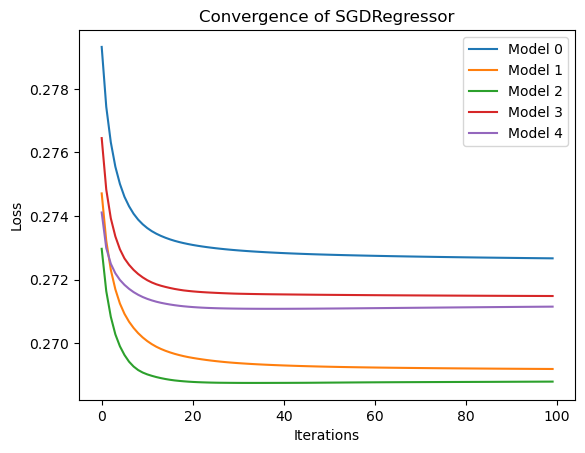

In [29]:

#########################################
#--------SGD Cross validation Training 
#########################################
number_of_models = 5
best_SGD_model_list = []
best_parameters_list = []
val_error_list = []
loss_values_list = []

# Perform cross validation
for i in range(number_of_models):
    print("-----\nModel: ", i)
    x_train, x_val, y_train, y_val = train_test_split(x_seen, y_seen, test_size=0.2, random_state=i)
    best_model,best_params, error, loss_values = train_and_test_SGD(x_train, y_train, x_val, y_val)
    best_SGD_model_list.append(best_model)
    best_parameters_list.append(best_params)
    val_error_list.append(error)
    loss_values_list.append(loss_values)

print('Best parameters: ', best_parameters_list)
norm_val_error = np.mean(np.array(val_error_list))
print('Normalized MAE on error sets: ', norm_val_error)

# Plot the convergence graph
for i, loss_values in enumerate(loss_values_list):
    plt.plot(loss_values, label=f'Model {i}')
    
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Convergence of SGDRegressor')
plt.legend()
plt.show()

### <font color="orange">  **Tests** </font>

In [12]:
#########################################
#--------KNN prediction on seen data 
#########################################

y_pred_seen_KNN_models = []
y_pred_unseen_KNN = []
Y_pred_KNN = []

#Make all the models in best_KNN_model_list to predict the x_seen, x_unseen, X_scaled and store the prediction
for model in best_KNN_model_list:
    y_pred_seen_KNN_models.append(model.predict(x_seen)) 

for model in best_KNN_model_list:
    y_pred_unseen_KNN.append(model.predict(x_unseen)) 

for model in best_KNN_model_list:
    Y_pred_KNN.append(model.predict(X_scaled)) 

# Takes the mean of all the predictions for the same data point in x_seen
y_pred_seen_KNN = np.mean(y_pred_seen_KNN_models,axis=0)
y_pred_unseen_KNN =  np.mean(y_pred_unseen_KNN, axis = 0)
Y_pred_KNN = np.mean(Y_pred_KNN, axis = 0)

#Calculates the errors. Recal that it is actually a rooted ratio, since it is a division of the difference of two logs
error_y_pred_seen_KNN = np.mean(np.abs(y_seen - np.array(y_pred_seen_KNN)))
errror_y_pred_unseen_KNN = np.mean(np.abs(y_unseen - np.array(y_pred_unseen_KNN)))
error_Y_KNN = np.mean(np.abs(Y - np.array(Y_pred_KNN)))

print("KNN MAE in prediction of y_seen: ", error_y_pred_seen_KNN)
print("KNN MAE in prediction of y_unseen: ", errror_y_pred_unseen_KNN)
print("KNN MAE in prediction of Y:", error_Y_KNN)


KNN MAE in prediction of y_seen (in log10):  0.2575365619198534
KNN MAE in prediction of y_unseen (in log10):  0.27264704498509723
KNN MAE in prediction of Y (in log10): 0.26055865853290217


In [22]:
# Instantiate the SGDRegressor
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

# Define the parameter grid for alpha (regularization strength) and learning rate
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Tuning regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Different learning rate strategies
    'eta0': [0.001, 0.01, 0.1, 1]  # Initial learning rate for strategies that require it
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(sgd_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_sgd = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_sgd.predict(X_test_scaled)

# Evaluate the model using MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Best MAE: {mae}")
print(f"Best Parameters: {grid_search.best_params_}")

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stocha

Best MAE: 0.27692806009280757
Best Parameters: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive'}


In [ ]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([1.0])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
# your predictions here should again be the $log_{10}(wage)$ of the football player, just as in the provided data. 
predictions_autograder_data = np.array([-1] * 14178)

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)